Please collect data for the top `1000 submissions` and `all the comments` on those submissions for the subreddits `wallstreetbets` and `StockMarket`.

The goal will be to classify submissions, i.e., to `predict` which `subreddit` each submission belongs to.

In [1]:
# download necessary libraries
!pip install praw
!pip install pytz
!pip install nltk

In [2]:
# import libraries
import os
import json
from typing import List, Dict

import praw

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/qazybek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# read secrets
with open('secrets.json', 'r') as file:
    secrets = json.loads(file.read())

In [4]:
# init reddit api handler
reddit = praw.Reddit(
    client_id=secrets['client_id'],
    client_secret=secrets['secret'],
    user_agent=secrets['user_agent']
)

In [5]:
subreddits = ['wallstreetbets', 'StockMarket']

In [6]:
%%time

submissions = []

# for each subreddit
for subreddit in subreddits:
    # download 1000 submissions
    for submission in reddit.subreddit(subreddit).hot(limit=1000):
        submissions.append([
            submission.id,
            submission.title,
            submission.selftext,
            submission.comments,
            subreddit
        ])

CPU times: user 24.1 s, sys: 675 ms, total: 24.7 s
Wall time: 25min 25s


In [7]:
df = pd.DataFrame(submissions, columns=['id', 'title', 'selftext', 'comments', 'class'])
df.set_index('id')
df.head()

,id,title,selftext,comments,class
0,nn680g,Weekend Discussion Thread for the Weekend of M...,Your weekend discussion thread. Please keep th...,"(gzsq7hs, gzv7tqh, gzsriz4, gzstlgo, gzstaza, ...",wallstreetbets
1,nng6r6,Most Anticipated Earnings Releases for the wee...,,"(h00szj7, h00ngew, h00t09b, h015ub1, h016lb0, ...",wallstreetbets
2,nol0ei,Power of the YOLO!,,"(h00za0m, h00ktzi, h00l5lq, h00qjc4, h00kwao, ...",wallstreetbets
3,noi60w,My investment vs Wall Street.,,"(h005vqw, h005mvk, h005kl3, h006bee, h01dffd, ...",wallstreetbets
4,nosznl,People are missing the point on Burry's $534m ...,People don't see the full idea behind Michael ...,"(h01qb3z, h01uesj, h01wspe, h020he2, h01qhex, ...",wallstreetbets


<!-- # # replace empty strings with np.nan
# df.loc[1]['selftext'] -->

In [8]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y, X_test, y_test):
#         breakpoint()
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        self.f1_scores = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
            
            y_pred = self.predict(X_test)
            score = f1_score(y_pred, y_test)
            self.f1_scores.append(score)

        return self

    def net_input(self, X):
        """Calculate net input"""
#         breakpoint()
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [9]:
df.head()

,id,title,selftext,comments,class
0,nn680g,Weekend Discussion Thread for the Weekend of M...,Your weekend discussion thread. Please keep th...,"(gzsq7hs, gzv7tqh, gzsriz4, gzstlgo, gzstaza, ...",wallstreetbets
1,nng6r6,Most Anticipated Earnings Releases for the wee...,,"(h00szj7, h00ngew, h00t09b, h015ub1, h016lb0, ...",wallstreetbets
2,nol0ei,Power of the YOLO!,,"(h00za0m, h00ktzi, h00l5lq, h00qjc4, h00kwao, ...",wallstreetbets
3,noi60w,My investment vs Wall Street.,,"(h005vqw, h005mvk, h005kl3, h006bee, h01dffd, ...",wallstreetbets
4,nosznl,People are missing the point on Burry's $534m ...,People don't see the full idea behind Michael ...,"(h01qb3z, h01uesj, h01wspe, h020he2, h01qhex, ...",wallstreetbets


In [10]:
nltk.download('averaged_perceptron_tagger')

def avg_com_speech_part_nums(comments: List, speech_part) -> float:
    if len(comments) == 0:
        return 0

    nums = []
    for comment in comments:
        try:
            words = word_tokenize(comment.body)
            tags = nltk.pos_tag(words)
            
            count = 0
            for tag in tags:
                if tag[1] == speech_part:
                    count += 1

            nums.append(count)
        except:
            pass

    avg_nums = round(sum(nums) / len(comments), 1)
    return avg_nums

# avg_com_speech_part_nums(df.iloc[0]['comments'].list(), 'NN')
# avg_com_speech_part_nums(df.iloc[0]['comments'].list(), 'VB')
# avg_com_speech_part_nums(df.iloc[0]['comments'].list(), 'JJ')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/qazybek/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')


def avg_com_stopwords_num(comments: List) -> float:
    if len(comments) == 0:
        return 0

    stopwords_nums = []
    for comment in comments:
        try:
            words = word_tokenize(comment.body)
            stopwords_num = sum([1 if word in stopwords_list else 0 for word in words]) / len(words)
            stopwords_nums.append(stopwords_num)
        except:
            pass

    avg_stopwords_nums = round(sum(stopwords_nums) / len(comments), 1)
    return avg_stopwords_nums

# avg_com_word_len(df.iloc[0]['comments'].list())

In [12]:
def avg_com_word_len(comments: List) -> float:
    if len(comments) == 0:
        return 0

    word_len = []
    for comment in comments:
        try:
            words = word_tokenize(comment.body)
            lens = [len(word) for word in words]
            avg_len = sum(lens) / len(words)
            word_len.append(avg_len)
        except:
            pass

    avg_word_len = round(sum(word_len) / len(comments), 1)
    return avg_word_len

# avg_com_word_len(df.iloc[0]['comments'].list())

In [13]:
def avg_com_word_num(comments: List) -> float:
    if len(comments) == 0:
        return 0

    word_num = []
    for comment in comments:
        try:
            word_num.append(len(word_tokenize(comment.body)))
        except:
            pass

    avg_word_num = round(sum(word_num) / len(comments), 1)
    return avg_word_num

# avg_com_word_num(df.iloc[0]['comments'].list())

In [14]:
def com_num(comment: List) -> int:
    return len(comment)

def avg_com_len(comments: List) -> float:
    if len(comments) == 0:
        return 0

    lens = []
    for comment in comments:
        try:
            lens.append(len(comment.body))
        except:
            pass

    avg_len = round(sum(lens) / len(comments), 1)
    return avg_len

In [15]:
class RedditClassifier(Perceptron):    
    def __init__(self, eta=0.01, n_iter=50, random_state=1, category='subreddit', category_values=['wallstreetbets', 'StockMarket']):
        super().__init__(eta=eta, n_iter=n_iter, random_state=random_state)
        self.cat: str = category
        # work only for binary classes
        self.cat_vals: Dict = {
                               category_values[0]: -1,
                               category_values[1]: 1
                              }
        
    def fit_predict(self, data):
        X, y = self.preprocessing(data)
        est = self.estimation(X, y)
        
        return est
    
    def preprocessing(self, data):
        prep_data = pd.DataFrame()
        y = data['class'].apply(lambda x: self.cat_vals[x])        
        
        prep_data['title_len'] = data['title'].apply(lambda x: len(x))
        
        # get comments text
        comments_df = data['comments'].transform([self.prep_comments])
        comments_df.columns = comments_df.columns.droplevel()

        # concatenate comments_df to prep_data on axis=1
        
        prep_data = pd.concat([prep_data, comments_df], axis=1, join='inner')
        return prep_data, y
        
    def prep_comments(self, comments: pd.Series):   
        comments_df = pd.DataFrame(index=comments.index)

        comments_df['com_num'] = comments.apply(lambda x: com_num(x))
        comments_df['avg_com_len'] = comments.apply(lambda x: avg_com_len(x))
        
        comments_df['avg_com_word_num'] = comments.apply(lambda x: avg_com_word_num(x))
        comments_df['avg_com_word_len'] = comments.apply(lambda x: avg_com_word_len(x))
        comments_df['avg_com_stopwords_num'] = comments.apply(lambda x: avg_com_stopwords_num(x))
        
        comments_df['avg_noun_nums'] = comments.apply(lambda x: avg_com_speech_part_nums(x, 'NN'))
        comments_df['avg_verbs_nums'] = comments.apply(lambda x: avg_com_speech_part_nums(x, 'VB'))
        comments_df['avg_adjective_nums'] = comments.apply(lambda x: avg_com_speech_part_nums(x, 'JJ'))

        return comments_df
    
    
    def estimation(self, X, y):
        # split the data and shuffle
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)  # stratify=True
        
        self.fit(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())
        y_pred = self.predict(X_test.to_numpy())
        
        return f1_score(y_pred, y_test.to_numpy())


In [16]:
%%time

etas = [0.02, 0.01, 0.001, 0.0001]

scores = []
for eta in etas:
    model = RedditClassifier(eta=eta, n_iter=150, random_state=1)
    model.fit_predict(df)
    
    scores.append(model.f1_scores)

CPU times: user 5min 52s, sys: 2.32 s, total: 5min 54s
Wall time: 5min 58s


In [17]:
scores_neg = []
for s in scores:
    scores_neg.append([1 - score for score in s])

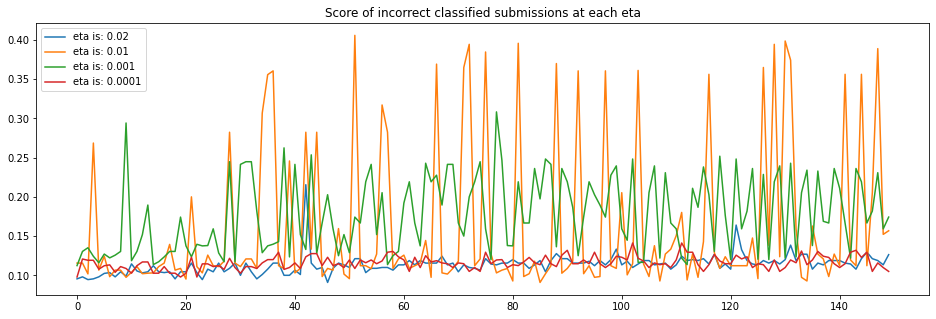

In [18]:
plt.figure(figsize=(16, 5))
for eta, score in zip(etas, scores_neg):
    plt.plot(score, label=f'eta is: {eta}')

plt.title('Score of incorrect classified submissions at each eta')
plt.legend()
plt.show()